# Spike-Field Coupling Detection: Method Comparison

**Methods:**
1. **PLV** - Phase-Locking Value (permutation test)
2. **SFC** - Spike-Field Coherence (permutation test)
3. **Joint** - Bayesian Joint Inference (Wald test)

**Analyses:**
- Effect size and p-value heatmaps
- ROC/PR curves using ALL frequency bands
- Sensitivity, Specificity, Precision, F1
- Phase recovery accuracy

In [1]:
import sys, os, pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np 
import seaborn as sns
from scipy import stats
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# ============================================================
# FIGURE STYLE
# ============================================================
def set_style(font_size=9):
    sns.set(style="ticks", context="paper", font="sans-serif",
            rc={"font.size": font_size, "axes.titlesize": font_size,
                "axes.labelsize": font_size, "axes.linewidth": 0.5,
                "lines.linewidth": 1.5, "xtick.labelsize": font_size,
                "ytick.labelsize": font_size, "legend.fontsize": font_size,
                "legend.frameon": False})
    matplotlib.rcParams['pdf.fonttype'] = 42

set_style()

# Colors
C = {'plv': '#2E86AB', 'sfc': '#A23B72', 'joint': '#F18F01'}

# Paths
WORKSPACE = "/orcd/data/ekmiller/001/bowen/spike-field-joint-inference"
if WORKSPACE not in sys.path:
    sys.path.append(WORKSPACE)

DATA_PATH = "./data/sim_with_trials.pkl"
JOINT_PATH = "./results/joint_inference.pkl"
PLV_PATH = "./results/plv_results.pkl"
SFC_PATH = "./results/sfc_results.pkl"
OUT = "./figures/"
os.makedirs(OUT, exist_ok=True)

# Parameters
FREQS = np.arange(1, 61, 2, dtype=float)  # [1, 3, ..., 59] Hz
ALPHA = 0.05
BURNIN = 0.5

## 1. Load Data

In [2]:
# Load simulation
from simulate_trial_data import TrialSimConfig
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)

freqs_true = np.asarray(data["freqs_hz"], float)  # True signal frequencies (coupled + signal-only)
freqs_coupled = np.asarray(data.get("freqs_hz_coupled", freqs_true), float)  # bands eligible to couple to spikes
freqs_extra = np.asarray(data.get("freqs_hz_extra", []), float)  # signal-only bands (no spike coupling)
freqs_true_int = freqs_true.astype(int)
freqs_coupled_int = freqs_coupled.astype(int)
freqs_extra_int = freqs_extra.astype(int)
masks = np.asarray(data["masks"], bool)  # (S, J_true) coupling mask

# True coupling parameters
if 'beta_mag' in data:
    beta_mag_true = np.asarray(data['beta_mag'])
    beta_phase_true = np.asarray(data['beta_phase'])
else:
    beta = np.asarray(data["beta_true"])
    J = len(freqs_true)
    bR, bI = beta[:, 1:1+J], beta[:, 1+J:1+2*J]
    beta_mag_true = np.sqrt(bR**2 + bI**2)
    beta_phase_true = np.arctan2(bI, bR)

S, J_true = masks.shape
B = len(FREQS)

# Map true freqs to dense grid
idx_map = np.array([np.argmin(np.abs(FREQS - f)) for f in freqs_true])

print(f"Units: {S}, True freqs: {freqs_true} Hz")
print(f"Coupling mask:\n{masks}")
print(f"True couplings: {masks.sum()}, Non-couplings: {(~masks).sum()}")

Units: 5, True freqs: [11. 19. 27. 43.  7. 35.] Hz
Coupling mask:
[[ True  True  True False False False]
 [ True  True False  True False False]
 [False  True  True  True False False]
 [ True  True  True False False False]
 [ True  True  True False False False]]
True couplings: 15, Non-couplings: 15


In [3]:
# Create FULL ground truth for ALL (unit, freq) pairs
# y_true[s, j] = True if unit s is coupled to freq j
y_true = np.zeros((S, B), dtype=bool)
for s in range(S):
    for jt, ft in enumerate(freqs_true):
        if masks[s, jt]:
            y_true[s, idx_map[jt]] = True

n_pos = y_true.sum()
n_neg = (~y_true).sum()
print(f"Full ground truth: {S}×{B} = {S*B} pairs")
print(f"  Positive (coupled): {n_pos}")
print(f"  Negative (not coupled): {n_neg}")
print(f"  Prevalence: {n_pos/(n_pos+n_neg):.1%}")

Full ground truth: 5×30 = 150 pairs
  Positive (coupled): 15
  Negative (not coupled): 135
  Prevalence: 10.0%


## 2. Load Method Results

In [4]:
# PLV
with open(PLV_PATH, 'rb') as f:
    plv_res = pickle.load(f)
plv_val = plv_res['plv']['values']  # (S, B)
plv_pval = plv_res['plv']['pval']
plv_phase = plv_res['plv']['phase']
print(f"PLV: {plv_val.shape}, range [{plv_val.min():.4f}, {plv_val.max():.4f}]")

# SFC
with open(SFC_PATH, 'rb') as f:
    sfc_res = pickle.load(f)
sfc_val = sfc_res['sfc']['values']
sfc_pval = sfc_res['sfc']['pval']
print(f"SFC: {sfc_val.shape}, range [{sfc_val.min():.4f}, {sfc_val.max():.4f}]")

# Joint
with open(JOINT_PATH, 'rb') as f:
    joint_res = pickle.load(f)
trace = joint_res['trace']['beta']
n_samp = trace.shape[0]
burn = int(BURNIN * n_samp)
post = trace[burn:]

bR = post[:, :, 1:1+B]
bI = post[:, :, 1+B:1+2*B]
mR, mI = bR.mean(0), bI.mean(0)
joint_mag = np.sqrt(mR**2 + mI**2)
joint_phase = np.arctan2(mI, mR)
print(f"Joint |β|: {joint_mag.shape}, range [{joint_mag.min():.4f}, {joint_mag.max():.4f}]")

PLV: (5, 30), range [0.0002, 0.0769]
SFC: (5, 30), range [0.0030, 0.2538]
Joint |β|: (5, 30), range [0.0000, 0.0492]


In [5]:
# Wald test for Joint
W = np.zeros((S, B))
joint_pval = np.zeros((S, B))

for s in range(S):
    for j in range(B):
        br, bi = bR[:, s, j], bI[:, s, j]
        mu = np.array([br.mean(), bi.mean()])
        Sig = np.cov(np.column_stack([br, bi]), rowvar=False) + 1e-10*np.eye(2)
        W[s,j] = mu @ np.linalg.solve(Sig, mu)
        joint_pval[s,j] = 1 - stats.chi2.cdf(W[s,j], df=2)

print(f"Wald W: [{W.min():.1f}, {W.max():.1f}]")

Wald W: [0.0, 477.3]


## 3. Heatmaps

In [6]:
def plot_heatmap(val, title, ax, freqs=FREQS, freqs_true=freqs_true, freqs_coupled=freqs_coupled, freqs_extra=freqs_extra, masks=masks,
                 idx_map=idx_map, cmap='viridis', log=False, pval=False):
    """Plot heatmap with stars at true couplings."""
    S, B = val.shape
    
    if log:
        v = np.log10(np.clip(val, 1e-10, None))
    elif pval:
        v = np.log10(np.clip(val, 1e-10, 1.0))
    else:
        v = val
    
    ext = [freqs[0], freqs[-1], -0.5, S-0.5]
    
    if pval:
        im = ax.imshow(v, aspect='auto', origin='lower', extent=ext,
                       cmap='viridis_r', vmin=-4, vmax=0, interpolation='nearest')
    else:
        im = ax.imshow(v, aspect='auto', origin='lower', extent=ext,
                       cmap=cmap, interpolation='nearest')
    
    # True freq lines
    for ft in freqs_true:
        ax.axvline(ft, color='white', ls='--', lw=0.6, alpha=0.5)
    
    # Stars at true couplings
    for s in range(S):
        for jt, ft in enumerate(freqs_true):
            if masks[s, jt]:
                ax.plot(ft, s, '*', color='red', ms=10, mec='white', mew=0.5)
    
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Unit')
    ax.set_yticks(range(S))
    ax.set_title(title, fontweight='bold')
    if len(freqs_extra) > 0:
        ax.text(0.99, 1.02, 'dotted: signal-only', transform=ax.transAxes,
                ha='right', va='bottom', fontsize=8, color='white')
    
    return im

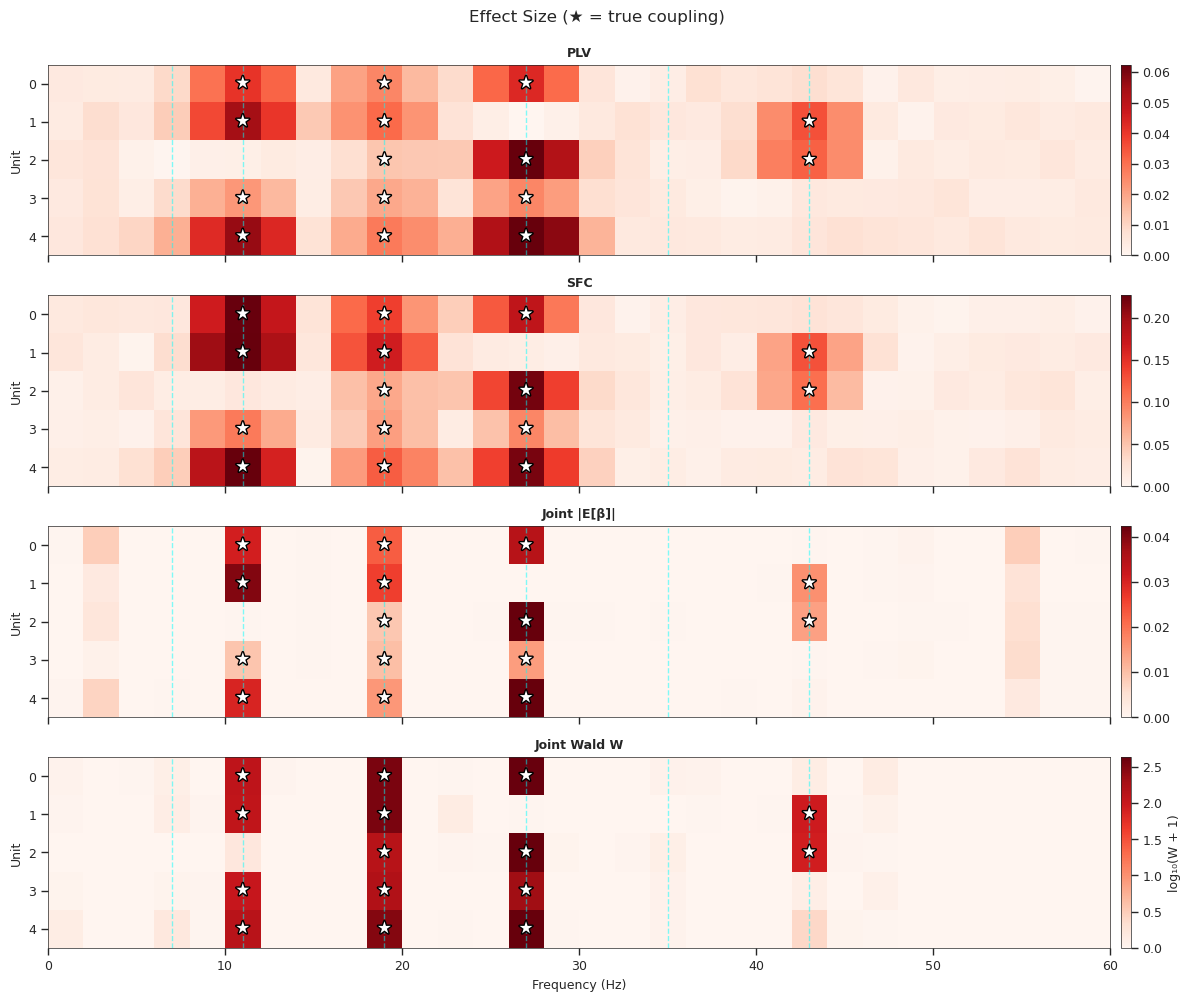

In [7]:
# ============================================================
# EFFECT SIZE HEATMAPS (Stacked rows, using original style)
# ============================================================
import matplotlib.patheffects as patheffects

def plot_effect_heatmap_row(ax, values, freqs, title, true_freqs, masks, 
                            log_scale=False, cmap='Reds', vmax_percentile=99):
    """Plot single effect size heatmap row with ★ markers."""
    
    if log_scale:
        plot_values = np.log10(values + 1)
        vmax = np.percentile(plot_values[np.isfinite(plot_values)], vmax_percentile)
    else:
        plot_values = values
        vmax = np.percentile(plot_values[np.isfinite(plot_values)], vmax_percentile)
    
    # Calculate frequency step to properly center pixels
    freq_step = freqs[1] - freqs[0] if len(freqs) > 1 else 1.0
    extent = [freqs[0] - freq_step/2, freqs[-1] + freq_step/2, 
              values.shape[0] - 0.5, -0.5]
    
    im = ax.imshow(plot_values, aspect='auto', cmap=cmap,
                   vmin=0, vmax=vmax, extent=extent)
    
    ax.set_ylabel('Unit')
    ax.set_title(title, fontweight='bold')
    
    # Mark true frequencies with vertical lines
    for f in true_freqs:
        ax.axvline(f, color='cyan', linestyle='--', alpha=0.5, lw=1)
    
    # Mark ONLY truly coupled with ★
    for s in range(masks.shape[0]):
        for j, f in enumerate(true_freqs):
            if masks[s, j]:
                ax.text(f, s, '★', ha='center', va='center',
                       fontsize=12, color='white', fontweight='bold',
                       path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])
    
    return im

# Create figure with 4 rows
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

effect_data = [plv_val, sfc_val, joint_mag, W]
effect_names = ['PLV', 'SFC', 'Joint |E[β]|', 'Joint Wald W']
log_flags = [False, False, False, True]

for ax, val, name, use_log in zip(axes, effect_data, effect_names, log_flags):
    im = plot_effect_heatmap_row(ax, val, FREQS, name, freqs_true, masks, 
                                  log_scale=use_log, cmap='Reds')
    cbar = fig.colorbar(im, ax=ax, fraction=0.02, pad=0.01)
    if use_log:
        cbar.set_label('log₁₀(W + 1)')

axes[-1].set_xlabel('Frequency (Hz)')

plt.suptitle('Effect Size (★ = true coupling)', fontsize=12, y=0.995)
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.savefig(f'{OUT}/heatmap_effect_stacked.png', dpi=150, bbox_inches='tight')
plt.savefig(f'{OUT}/heatmap_effect_stacked.pdf', dpi=150, bbox_inches='tight')
plt.show()

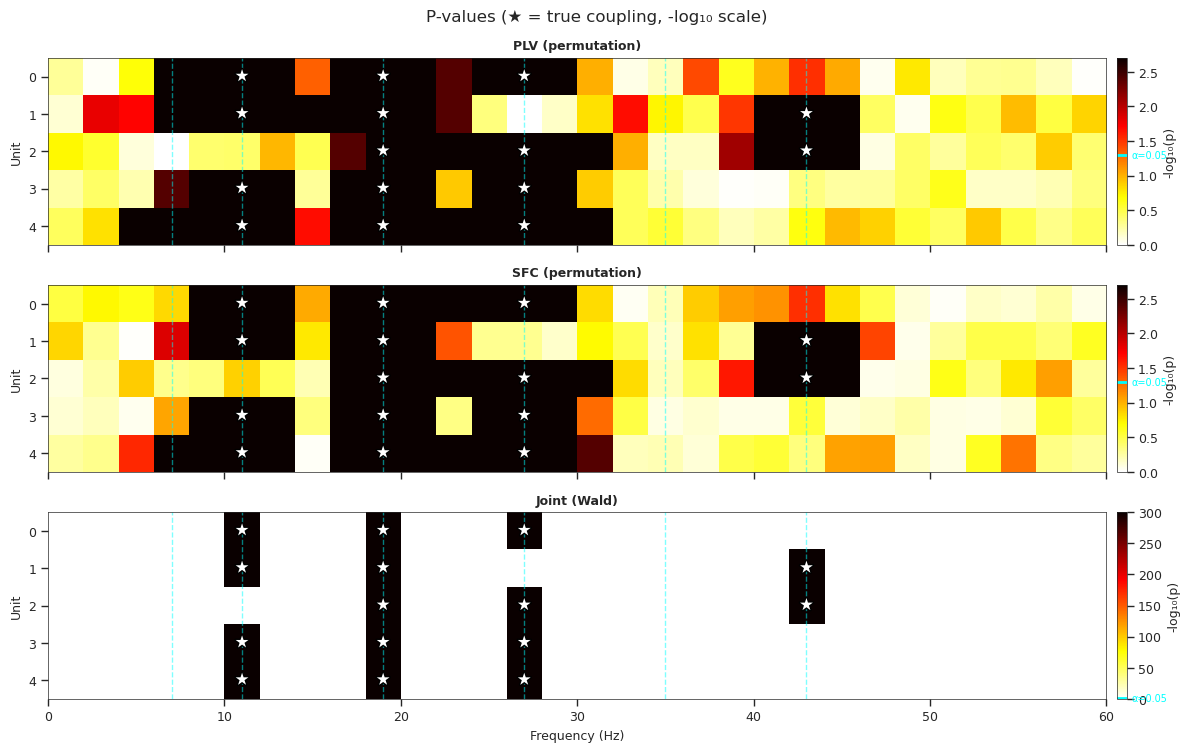

In [8]:
# ============================================================
# P-VALUE HEATMAPS (Stacked rows, SEPARATE colorbars)
# ============================================================

def plot_pval_heatmap_row(ax, pvals, freqs, title, true_freqs, masks, 
                          cmap='hot_r', vmin=0, vmax=10):
    """Plot single p-value heatmap row with ★ markers."""
    
    # -log10(p) for better visualization
    log_p = -np.log10(np.clip(pvals, 1e-300, 1))
    
    # Calculate frequency step to properly center pixels
    freq_step = freqs[1] - freqs[0] if len(freqs) > 1 else 1.0
    extent = [freqs[0] - freq_step/2, freqs[-1] + freq_step/2,
              pvals.shape[0] - 0.5, -0.5]
    
    im = ax.imshow(log_p, aspect='auto', cmap=cmap,
                   vmin=vmin, vmax=vmax, extent=extent)
    
    ax.set_ylabel('Unit')
    ax.set_title(title, fontweight='bold')
    
    # Mark true frequencies with vertical lines
    for f in true_freqs:
        ax.axvline(f, color='cyan', linestyle='--', alpha=0.5, lw=1)
    
    # Mark ONLY truly coupled with ★
    for s in range(masks.shape[0]):
        for j, f in enumerate(true_freqs):
            if masks[s, j]:
                ax.text(f, s, '★', ha='center', va='center',
                       fontsize=12, color='white', fontweight='bold',
                       path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])
    
    return im

# Create figure with 3 rows
fig, axes = plt.subplots(3, 1, figsize=(12, 7.5), sharex=True)

pval_data = [plv_pval, sfc_pval, joint_pval]
pval_names = ['PLV (permutation)', 'SFC (permutation)', 'Joint (Wald)']

# Compute separate vmax for each method based on data
for ax, pv, name in zip(axes, pval_data, pval_names):
    # Compute -log10(p) and set vmax based on data
    log_p = -np.log10(np.clip(pv, 1e-300, 1))
    vmax_data = np.percentile(log_p[np.isfinite(log_p)], 99)
    vmax_data = max(vmax_data, -np.log10(ALPHA) + 1)  # At least show significance threshold
    
    im = plot_pval_heatmap_row(ax, pv, FREQS, name, freqs_true, masks, 
                                cmap='hot_r', vmin=0, vmax=vmax_data)
    
    # Individual colorbar for each row
    cbar = fig.colorbar(im, ax=ax, fraction=0.02, pad=0.01)
    cbar.set_label('-log₁₀(p)')
    
    # Add significance threshold line on each colorbar
    sig_line = -np.log10(ALPHA)
    if sig_line <= vmax_data:
        cbar.ax.axhline(sig_line, color='cyan', lw=2)
        cbar.ax.text(1.5, sig_line, f'α={ALPHA}', color='cyan', fontsize=7, va='center')

axes[-1].set_xlabel('Frequency (Hz)')

plt.suptitle('P-values (★ = true coupling, -log₁₀ scale)', fontsize=12, y=0.995)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig(f'{OUT}/heatmap_pval_stacked.png', dpi=150, bbox_inches='tight')
plt.savefig(f'{OUT}/heatmap_pval_stacked.pdf', dpi=150, bbox_inches='tight')
plt.show()

## 4. ROC & Precision-Recall (All Frequency Bands)

In [9]:
# Flatten for ROC
y = y_true.flatten()

# Scores: -log(p) so higher = more significant
s_plv = -np.log10(np.clip(plv_pval, 1e-10, 1)).flatten()
s_sfc = -np.log10(np.clip(sfc_pval, 1e-10, 1)).flatten()
s_joint = -np.log10(np.clip(joint_pval, 1e-10, 1)).flatten()

# Also effect size scores
e_plv = plv_val.flatten()
e_sfc = sfc_val.flatten()
e_joint = joint_mag.flatten()

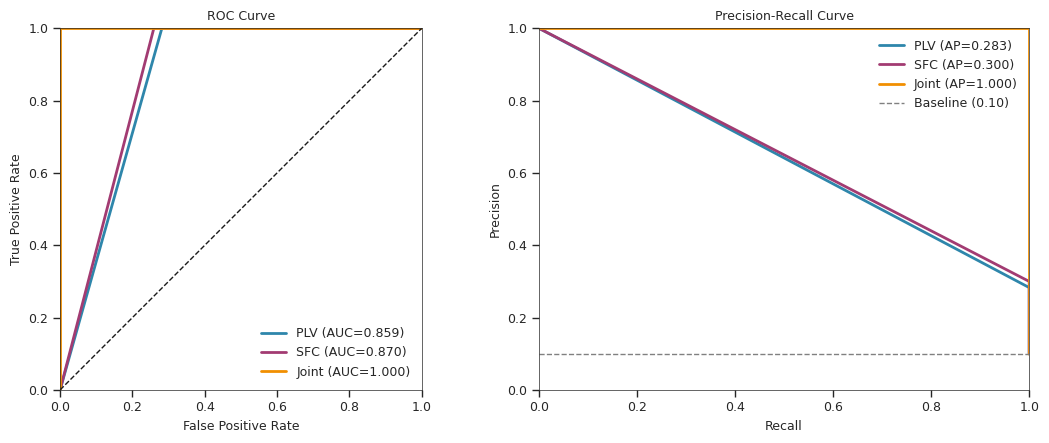


AUC (using -log(p-value) as score):
  PLV: 0.859
  SFC: 0.870
  Joint: 1.000


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))

# ROC - p-value scores
ax = axes[0]
for score, name, c in [(s_plv, 'PLV', C['plv']), 
                        (s_sfc, 'SFC', C['sfc']), 
                        (s_joint, 'Joint', C['joint'])]:
    fpr, tpr, _ = roc_curve(y, score)
    a = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=c, lw=2, label=f'{name} (AUC={a:.3f})')

ax.plot([0,1], [0,1], 'k--', lw=1)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend(loc='lower right')
ax.set_aspect('equal')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# Precision-Recall
ax = axes[1]
for score, name, c in [(s_plv, 'PLV', C['plv']), 
                        (s_sfc, 'SFC', C['sfc']), 
                        (s_joint, 'Joint', C['joint'])]:
    prec, rec, _ = precision_recall_curve(y, score)
    ap = average_precision_score(y, score)
    ax.plot(rec, prec, color=c, lw=2, label=f'{name} (AP={ap:.3f})')

ax.axhline(y.mean(), color='gray', ls='--', lw=1, label=f'Baseline ({y.mean():.2f})')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.legend(loc='upper right')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(f'{OUT}/roc_pr_curves.png', dpi=150, bbox_inches='tight')
plt.savefig(f'{OUT}/roc_pr_curves.pdf', dpi=150, bbox_inches='tight')
plt.show()

# Print AUCs
print("\nAUC (using -log(p-value) as score):")
for score, name in [(s_plv, 'PLV'), (s_sfc, 'SFC'), (s_joint, 'Joint')]:
    fpr, tpr, _ = roc_curve(y, score)
    print(f"  {name}: {auc(fpr, tpr):.3f}")

## 5. Detection Metrics @ α = 0.05

In [11]:
def metrics(y_true, pval, alpha=ALPHA):
    """Compute detection metrics using ALL bands."""
    y_pred = (pval < alpha).flatten()
    y = y_true.flatten()
    
    TP = (y_pred & y).sum()
    TN = (~y_pred & ~y).sum()
    FP = (y_pred & ~y).sum()
    FN = (~y_pred & y).sum()
    
    sens = TP/(TP+FN) if TP+FN > 0 else 0
    spec = TN/(TN+FP) if TN+FP > 0 else 0
    prec = TP/(TP+FP) if TP+FP > 0 else 0
    f1 = 2*prec*sens/(prec+sens) if prec+sens > 0 else 0
    
    return {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
            'sens': sens, 'spec': spec, 'prec': prec, 'f1': f1}

m_plv = metrics(y_true, plv_pval)
m_sfc = metrics(y_true, sfc_pval)
m_joint = metrics(y_true, joint_pval)

print(f"Detection Metrics @ α = {ALPHA}")
print(f"Total: {S*B} pairs, Pos: {n_pos}, Neg: {n_neg}")
print()
print(f"{'':12} {'PLV':>10} {'SFC':>10} {'Joint':>10}")
print("-"*45)
print(f"{'TP':12} {m_plv['TP']:>10} {m_sfc['TP']:>10} {m_joint['TP']:>10}")
print(f"{'FP':12} {m_plv['FP']:>10} {m_sfc['FP']:>10} {m_joint['FP']:>10}")
print(f"{'TN':12} {m_plv['TN']:>10} {m_sfc['TN']:>10} {m_joint['TN']:>10}")
print(f"{'FN':12} {m_plv['FN']:>10} {m_sfc['FN']:>10} {m_joint['FN']:>10}")
print("-"*45)
print(f"{'Sensitivity':12} {m_plv['sens']:>10.3f} {m_sfc['sens']:>10.3f} {m_joint['sens']:>10.3f}")
print(f"{'Specificity':12} {m_plv['spec']:>10.3f} {m_sfc['spec']:>10.3f} {m_joint['spec']:>10.3f}")
print(f"{'Precision':12} {m_plv['prec']:>10.3f} {m_sfc['prec']:>10.3f} {m_joint['prec']:>10.3f}")
print(f"{'F1':12} {m_plv['f1']:>10.3f} {m_sfc['f1']:>10.3f} {m_joint['f1']:>10.3f}")

Detection Metrics @ α = 0.05
Total: 150 pairs, Pos: 15, Neg: 135

                    PLV        SFC      Joint
---------------------------------------------
TP                   15         15         15
FP                   51         42          0
TN                   84         93        135
FN                    0          0          0
---------------------------------------------
Sensitivity       1.000      1.000      1.000
Specificity       0.622      0.689      1.000
Precision         0.227      0.263      1.000
F1                0.370      0.417      1.000


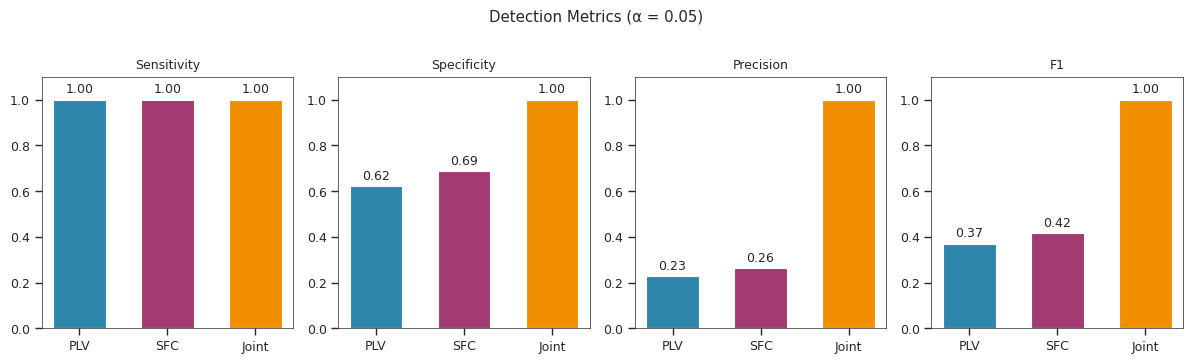

In [12]:
# Bar plot
fig, axes = plt.subplots(1, 4, figsize=(12, 3.5))

for ax, key, name in zip(axes, ['sens', 'spec', 'prec', 'f1'],
                          ['Sensitivity', 'Specificity', 'Precision', 'F1']):
    vals = [m_plv[key], m_sfc[key], m_joint[key]]
    bars = ax.bar(['PLV', 'SFC', 'Joint'], vals, 
                  color=[C['plv'], C['sfc'], C['joint']], width=0.6)
    ax.set_ylim([0, 1.1])
    ax.set_title(name)
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, v + 0.03, f'{v:.2f}', 
                ha='center', fontsize=9)

plt.suptitle(f'Detection Metrics (α = {ALPHA})', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUT}/metrics_bars.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Phase Recovery

In [13]:
def circ_diff(a, b):
    return np.arctan2(np.sin(a-b), np.cos(a-b))

# Only coupled pairs
coupled = masks.flatten()
true_ph = beta_phase_true.flatten()[coupled]
joint_ph = joint_phase[:, idx_map].flatten()[coupled]
plv_ph = plv_phase[:, idx_map].flatten()[coupled]

err_joint = circ_diff(joint_ph, true_ph)
err_plv = circ_diff(plv_ph, true_ph)

mae_joint = np.abs(err_joint).mean()
mae_plv = np.abs(err_plv).mean()

print(f"Phase MAE (coupled pairs, n={coupled.sum()}):")
print(f"  Joint: {np.degrees(mae_joint):.1f}°")
print(f"  PLV:   {np.degrees(mae_plv):.1f}°")

Phase MAE (coupled pairs, n=15):
  Joint: 11.8°
  PLV:   24.0°


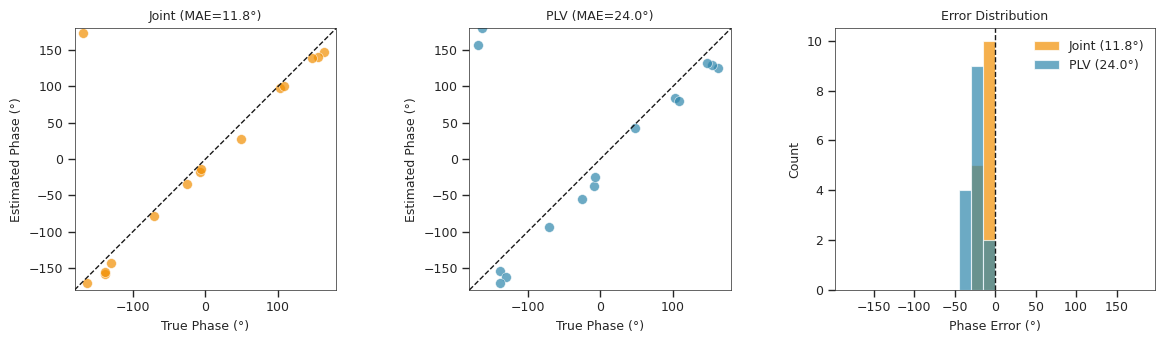

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

# Joint scatter
ax = axes[0]
ax.scatter(np.degrees(true_ph), np.degrees(joint_ph), 
           c=C['joint'], s=50, alpha=0.7, edgecolors='white', lw=0.5)
ax.plot([-180, 180], [-180, 180], 'k--', lw=1)
ax.set_xlabel('True Phase (°)')
ax.set_ylabel('Estimated Phase (°)')
ax.set_title(f'Joint (MAE={np.degrees(mae_joint):.1f}°)')
ax.set_xlim([-180, 180])
ax.set_ylim([-180, 180])
ax.set_aspect('equal')

# PLV scatter
ax = axes[1]
ax.scatter(np.degrees(true_ph), np.degrees(plv_ph),
           c=C['plv'], s=50, alpha=0.7, edgecolors='white', lw=0.5)
ax.plot([-180, 180], [-180, 180], 'k--', lw=1)
ax.set_xlabel('True Phase (°)')
ax.set_ylabel('Estimated Phase (°)')
ax.set_title(f'PLV (MAE={np.degrees(mae_plv):.1f}°)')
ax.set_xlim([-180, 180])
ax.set_ylim([-180, 180])
ax.set_aspect('equal')

# Error histogram
ax = axes[2]
bins = np.linspace(-180, 180, 25)
ax.hist(np.degrees(err_joint), bins, alpha=0.7, color=C['joint'], 
        label=f'Joint ({np.degrees(mae_joint):.1f}°)', edgecolor='white')
ax.hist(np.degrees(err_plv), bins, alpha=0.7, color=C['plv'],
        label=f'PLV ({np.degrees(mae_plv):.1f}°)', edgecolor='white')
ax.axvline(0, color='k', ls='--', lw=1)
ax.set_xlabel('Phase Error (°)')
ax.set_ylabel('Count')
ax.set_title('Error Distribution')
ax.legend()

plt.tight_layout()
plt.savefig(f'{OUT}/phase_recovery.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Summary

In [15]:
# Compute AUCs
auc_plv = auc(*roc_curve(y, s_plv)[:2])
auc_sfc = auc(*roc_curve(y, s_sfc)[:2])
auc_joint = auc(*roc_curve(y, s_joint)[:2])

print("="*60)
print("SUMMARY")
print("="*60)
print(f"\nROC-AUC (using -log(p-value)):")
print(f"  PLV:   {auc_plv:.3f}")
print(f"  SFC:   {auc_sfc:.3f}")
print(f"  Joint: {auc_joint:.3f}")
print(f"\nDetection @ α={ALPHA}:")
print(f"  {'':10} {'Sens':>8} {'Spec':>8} {'Prec':>8} {'F1':>8}")
print(f"  {'PLV':10} {m_plv['sens']:>8.3f} {m_plv['spec']:>8.3f} {m_plv['prec']:>8.3f} {m_plv['f1']:>8.3f}")
print(f"  {'SFC':10} {m_sfc['sens']:>8.3f} {m_sfc['spec']:>8.3f} {m_sfc['prec']:>8.3f} {m_sfc['f1']:>8.3f}")
print(f"  {'Joint':10} {m_joint['sens']:>8.3f} {m_joint['spec']:>8.3f} {m_joint['prec']:>8.3f} {m_joint['f1']:>8.3f}")
print(f"\nPhase MAE:")
print(f"  PLV:   {np.degrees(mae_plv):.1f}°")
print(f"  Joint: {np.degrees(mae_joint):.1f}°")

SUMMARY

ROC-AUC (using -log(p-value)):
  PLV:   0.859
  SFC:   0.870
  Joint: 1.000

Detection @ α=0.05:
                 Sens     Spec     Prec       F1
  PLV           1.000    0.622    0.227    0.370
  SFC           1.000    0.689    0.263    0.417
  Joint         1.000    1.000    1.000    1.000

Phase MAE:
  PLV:   24.0°
  Joint: 11.8°


In [16]:
# Save results
results = {
    'config': {'freqs': FREQS, 'freqs_true': freqs_true, 'alpha': ALPHA},
    'ground_truth': {'masks': masks, 'y_true': y_true},
    'plv': {'val': plv_val, 'pval': plv_pval, 'phase': plv_phase, 
            'metrics': m_plv, 'auc': auc_plv},
    'sfc': {'val': sfc_val, 'pval': sfc_pval, 
            'metrics': m_sfc, 'auc': auc_sfc},
    'joint': {'mag': joint_mag, 'pval': joint_pval, 'phase': joint_phase,
              'metrics': m_joint, 'auc': auc_joint},
    'phase': {'mae_joint': mae_joint, 'mae_plv': mae_plv},
}

with open(f'{OUT}/comparison_results.pkl', 'wb') as f:
    pickle.dump(results, f)
print(f"Saved to {OUT}/comparison_results.pkl")

Saved to ./figures//comparison_results.pkl
